# Project 4

This project applies programming skills acquired during the course to re-analyze microscopy data using Cellpose, comparing its segmentation results with those from the Nessys algorithm.

The authors of the PLOS Biology paper, "Nessys: A new set of tools for the automated detection of nuclei within intact tissues and dense 3D cultures" (Blin et al., 2019) introduced a novel nuclear segmentation method. Their images were processed using Nessys, an extensible Java-based automated cell nuclei identification software. The images and analytical results are available in the Image Data Resource (IDR):
- <https://doi.org/10.1371/journal.pbio.3000388>
- <https://idr.openmicroscopy.org/webclient/?show=project-801>

The IDR team has also converted the dataset into OME-Zarr format. Unlike Nessys, Cellpose was not used in the original study. 

## Local TIFF files

The dataset is available in the IDR, but first, we are going to download the B4_C3.tif file from the IDR and save it locally. We will then use Cellpose to segment the nuclei in the image and compare the results with those obtained using Nessys.

### 1. Load libraries

In [1]:
# Import libraries
import bioio
import cellpose
import cellpose.models
import dask
from ipywidgets import *
import matplotlib.pyplot as plt
import numpy
import pandas
from scipy.spatial.distance import dice
from scipy.stats import pearsonr
from skimage.metrics import contingency_table
from skimage.filters import gaussian
from sklearn.metrics import jaccard_score, precision_score, recall_score, r2_score

### 2. Download C3_B4.tif from IDR

Using the filepath, it is possible to download locally the image by running from a terminal:

```bash
wget https://ftp.ebi.ac.uk/pub/databases/IDR/idr0062-blin-nuclearsegmentation/20190429-ftp/Blastocysts/B4_C3.tif
```

or, alternatively, by using the Python `ftputil` library:

In [2]:
import ftputil
import os

files = [
    "pub/databases/IDR/idr0062-blin-nuclearsegmentation/20190429-ftp/Blastocysts/B4_C3.tif",
    "pub/databases/IDR/idr0062-blin-nuclearsegmentation/20190429-ftp/Blastocysts/B4_C3_Manual.tif",
]

with ftputil.FTPHost("ftp.ebi.ac.uk", "anonymous") as host:
    names = host.listdir(host.curdir)
    for name in names:
        if name == "pub":  # only check the IDR data
            for file in files:
                filepath = os.path.join("data", os.path.basename(file))
                if host.path.isfile(file):
                    host.download(file, filepath)

### 3. Try to open in BioIO

The `bioio` package requires `bioio-tifffile` plugin to be able to load the image as downloaded.

In [3]:
filepath = os.path.join("data", "B4_C3.tif")
labelspath = os.path.join("data", "B4_C3_Manual.tif")

In [4]:
# Load the image
images = bioio.BioImage(filepath)

# Load the label
_labels = bioio.BioImage(labelspath)

# (T, C, Z, Y, X)
print(images.dims)
print(images.shape)

<Dimensions [T: 1, C: 2, Z: 257, Y: 210, X: 253]>
(1, 2, 257, 210, 253)


In [5]:
def update(z=0, c=0):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(images.data[0, c, z, :, :])
    plt.tight_layout()
    fig.canvas.flush_events()


interact(
    update,
    z=widgets.IntSlider(
        value=0,
        min=0,
        max=images.data.shape[2] - 1,
        step=1,
        description="Select T",
        continuous_update=False,
    ),
    c=widgets.IntSlider(
        value=0,
        min=0,
        max=images.data.shape[1] - 1,
        step=1,
        description="Select C",
        continuous_update=False,
    ),
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Select T', max=256), IntSlider(…

<function __main__.update(z=0, c=0)>

### 4. Select two Z-planes around the middle of the stack

In [6]:
# Define the Z-planes to select
Z = [89, 90, 91]

# Select two Z-planes (indices 89 and 90) and stack them along a new axis
selected_images = numpy.stack([images.data[0, :, z, :, :] for z in Z], axis=1)

print(f"BioIO shape: {images.data.shape}")
print(f"Selected images shape: {selected_images.shape}")


BioIO shape: (1, 2, 257, 210, 253)
Selected images shape: (2, 3, 210, 253)


### 5. Process the selected planes using Cellpose API with the default cyto model

In [7]:
# Convert the NumPy image data to a Dask array
dask_img = dask.array.from_array(
    selected_images,
    chunks=(
        selected_images.shape[0],
        1,
        selected_images.shape[2],
        selected_images.shape[3],
    ),
)

dask_img

dask.array<array, shape=(2, 3, 210, 253), dtype=uint16, chunksize=(2, 1, 210, 253), chunktype=numpy.ndarray>

In [8]:
# Load the Cellpose model: cyto
model = cellpose.models.Cellpose(model_type="cyto3", gpu=True)

@dask.delayed
def segment(image):
    image = gaussian(image, sigma=0.5)
    masks, _, _, _ = model.eval(image, diameter=50, min_size=10, channels=[0,1])
    return masks

In [9]:
%%time
# Perform segmentation with Dask
_results = dask.compute(*[segment(dask_img[:,z,:,:]) for z in range(dask_img.shape[1])])

CPU times: user 4.45 s, sys: 1.24 s, total: 5.7 s
Wall time: 1.97 s


### 6. Display the segmentation results

We will use matplotlib to display the segmentation results. The output will show the Cellpose segmentation alongside the Nessys ground truth labels for comparison.

In [10]:
def update(z=0):
    fig = plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    # Original Image
    ax[0].imshow(dask_img[0][z], cmap="Blues")
    ax[0].imshow(dask_img[1][z], cmap="Reds")
    ax[0].set_title(f"Original - {Z[z] + 1}")
    ax[0].axis("off")
    
    # Segmented Image (Overlay)
    ax[1].imshow(dask_img[0][z], cmap="gray")
    ax[1].imshow(_results[z], alpha=0.5, cmap="jet")
    ax[1].set_title(f"Segmentation - {Z[z] + 1}")
    ax[1].axis("off")
    
    # Labels Image
    ax[2].imshow(_labels.data[0, 0, Z[z], :, :], cmap="jet")
    ax[2].set_title(f"Nessys' labels - {Z[z] + 1}")
    ax[2].axis("off")

    plt.tight_layout()
    fig.canvas.flush_events()

interact(
    update,
    z=widgets.IntSlider(
        value=0,
        min=0,
        max=len(_results) - 1,
        step=1,
        description="Select Z",
        continuous_update=False,
    ),
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Select Z', max=2), Output()), _…

<function __main__.update(z=0)>

## OME-Zarr files

In this step, we will use the OME-Zarr format to analyze [6001247.zarr](https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001247.zarr/0/) file. We will load the image using Dask and Cellpose and compare the results with the original Nessys segmentation.

### 1. Load 6001247.zarr file instead of TIFF

In [11]:
# Image information
IMAGE_ID = 6001247
ENPOINT_URL = 'https://uk1s3.embassy.ebi.ac.uk/'

In [12]:
# Define a function to load binary data from S3
def load_binary_from_s3(name, resolution='0'):
    root = '%s/%s/' % (name, resolution)
    return dask.array.from_zarr(ENPOINT_URL + root)

In [13]:
# Define the name of the Zarr file
name = 'idr/zarr/v0.1/%s.zarr' % IMAGE_ID

# Load the binary data from S3
data = load_binary_from_s3(name, resolution='0')

In [14]:
print(f"Dask array shape: {data.shape}")

Dask array shape: (1, 2, 257, 210, 253)


### 2. Read labels from the ome.zarr

In [15]:
# Define the name of the labels Zarr file
name = 'idr/zarr/v0.1/%s.zarr/labels' % IMAGE_ID

# Load the binary data from S3
labels = load_binary_from_s3(name)

In [16]:
print(f"Dask array shape: {labels.shape}")

Dask array shape: (1, 1, 257, 210, 253)


### 3. Analyze the image using Cellpose

In [17]:
%%time
# Perform segmentation with Dask
results = dask.compute(*[segment(data[0,:,z,:,:]) for z in range(data.shape[2])])

CPU times: user 5min 7s, sys: 49.3 s, total: 5min 57s
Wall time: 1min 1s


In [18]:
def update(z=0):
    fig = plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    # Original Image
    ax[0].imshow(data[0, 0, z, :, :], cmap="Blues")
    ax[0].imshow(data[0, 1, z, :, :], cmap="Reds", alpha=0.5)
    ax[0].set_title(f"Original (z={z + 1})")
    ax[0].axis("off")
    
    # Segmented Image (Overlay)
    ax[1].imshow(data[0, 0, z, :, :], cmap="gray")
    ax[1].imshow(results[z], alpha=0.5, cmap="jet")
    ax[1].set_title(f"Segmentation (z={z + 1})")
    ax[1].axis("off")
    
    # Labels Image
    ax[2].imshow(labels[0, 0, z, :, :], cmap="jet")
    ax[2].set_title(f"Nessys' labels (z={z + 1})")
    ax[2].axis("off")

    plt.tight_layout()
    fig.canvas.flush_events()

interact(
    update,
    z=widgets.IntSlider(
        value=0,
        min=0,
        max=len(results) - 1,
        step=1,
        description="Select T",
        continuous_update=False,
    ),
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Select T', max=256), Output()),…

<function __main__.update(z=0)>

### 4. Compare the labels with the Cellpose segmentation

We will compare Cellpose segmentations with Nessys labels using standard segmentation metrics. These metrics help evaluate overlap, precision, and segmentation accuracy.

1. Intersection over Union (IoU) - Jaccard Index

Measures overlap accuracy between predicted and ground truth segmentation.

$$
IoU = J(A,B) = \frac{|A \cap B|}{|A \cup B|} \in [0,1]
$$

- **0.0** → No overlap at all (bad segmentation)
- **1.0** → Perfect match (ideal segmentation)
- **> 0.5** → Generally considered a good match in many applications

2. Precision & Recall

These metrics evaluate over-segmentation (avoids False Positives - FP) vs. under-segmentation (avoids False Negatives - FN).

$$
Precision = \frac{TP}{TP + FP} \in [0,1]
$$

$$
Recall = \frac{TP}{TP + FN} \in [0,1]
$$

- **High precision, low recall**: Too conservative (many missed nuclei).  
- **High recall, low precision**: Too aggressive (detects too many false nuclei).  

3. Dice Coefficient (F1 Score for Segmentation)

Measures similarity between segmentation masks, commonly used in biomedical imaging.

$$
Dice = \frac{2|A \cap B|}{|A| + |B|} \in [0,1]
$$

- **0.0** → No overlap
- **1.0** → Perfect match

In [19]:
# Convert predictions to a numpy array
predictions = numpy.stack(results)

# Convert labels to a numpy array
ground_truth = labels[0,0,:,:,:].compute()

In [20]:
# Initialize metrics dictionary
metrics = {
    "jaccard": [],
    "precision": [],
    "recall": [],
    "dice": [],
    "ct": [],
}

# Iterate over predictions and ground truth
for pred, gt in zip(predictions, ground_truth):
    # Flatten arrays for computation
    pred_flat = pred.flatten() > 0
    gt_flat = gt.flatten() > 0

    # Compute metrics
    metrics["ct"].append(contingency_table(gt, pred))
    metrics["jaccard"].append(jaccard_score(gt_flat, pred_flat, average="macro"))
    metrics["precision"].append(precision_score(gt_flat, pred_flat, average="macro"))
    metrics["recall"].append(recall_score(gt_flat, pred_flat, average="macro"))
    metrics["dice"].append(1 - dice(gt_flat, pred_flat))

# Convert metrics to a DataFrame
metrics_df = pandas.DataFrame(metrics)

# Display the metrics DataFrame
metrics_df

/home/jvsguerra/remote-repos/jvsguerra/MDA_Project_4/.venv/lib/python3.12/site-packages/scipy/spatial/distance.py:1506: RuntimeWarning: invalid value encountered in divide
  return float((ntf + nft) / np.array(2.0 * ntt + ntf + nft))
/home/jvsguerra/remote-repos/jvsguerra/MDA_Project_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,jaccard,precision,recall,dice,ct
0,1.000000,1.000000,1.000000,NaN,<Compressed Sparse Row sparse matrix of dtype ...
1,0.478026,0.500000,0.478026,0.000000,<Compressed Sparse Row sparse matrix of dtype ...
2,0.534117,0.556691,0.977425,0.203673,<Compressed Sparse Row sparse matrix of dtype ...
3,0.619881,0.636170,0.983711,0.428094,<Compressed Sparse Row sparse matrix of dtype ...
4,0.677321,0.690412,0.986909,0.551589,<Compressed Sparse Row sparse matrix of dtype ...
...,...,...,...,...,...
252,0.745140,0.782537,0.962159,0.721880,<Compressed Sparse Row sparse matrix of dtype ...
253,0.732969,0.771696,0.961192,0.704117,<Compressed Sparse Row sparse matrix of dtype ...
254,0.714830,0.756999,0.957830,0.678995,<Compressed Sparse Row sparse matrix of dtype ...
255,0.628279,0.693338,0.934942,0.557702,<Compressed Sparse Row sparse matrix of dtype ...


#### Metrics visualization

jaccard      0.766127
precision    0.799934
recall       0.955087
dice         0.714514
dtype: float64


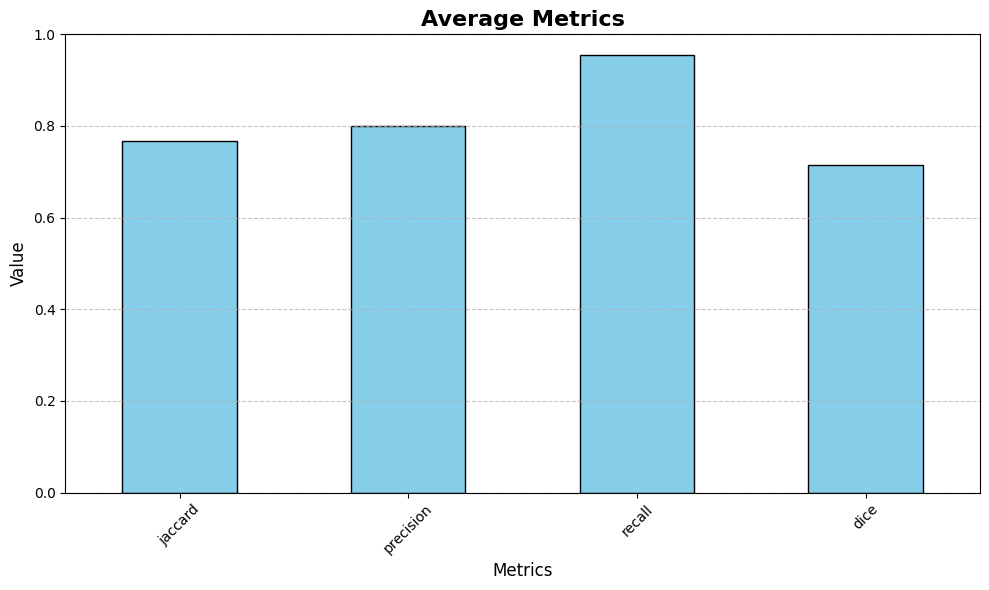

In [21]:
# Calculate average metrics
metrics_avg = metrics_df.drop(columns=["ct"]).mean()
print(metrics_avg)

# Plot
metrics_avg.plot.bar(
    figsize=(10, 6),
    color='skyblue',
    edgecolor='black',
    legend=False
)

plt.title("Average Metrics", fontsize=16, fontweight='bold')
plt.ylabel("Value", fontsize=12)
plt.xlabel("Metrics", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

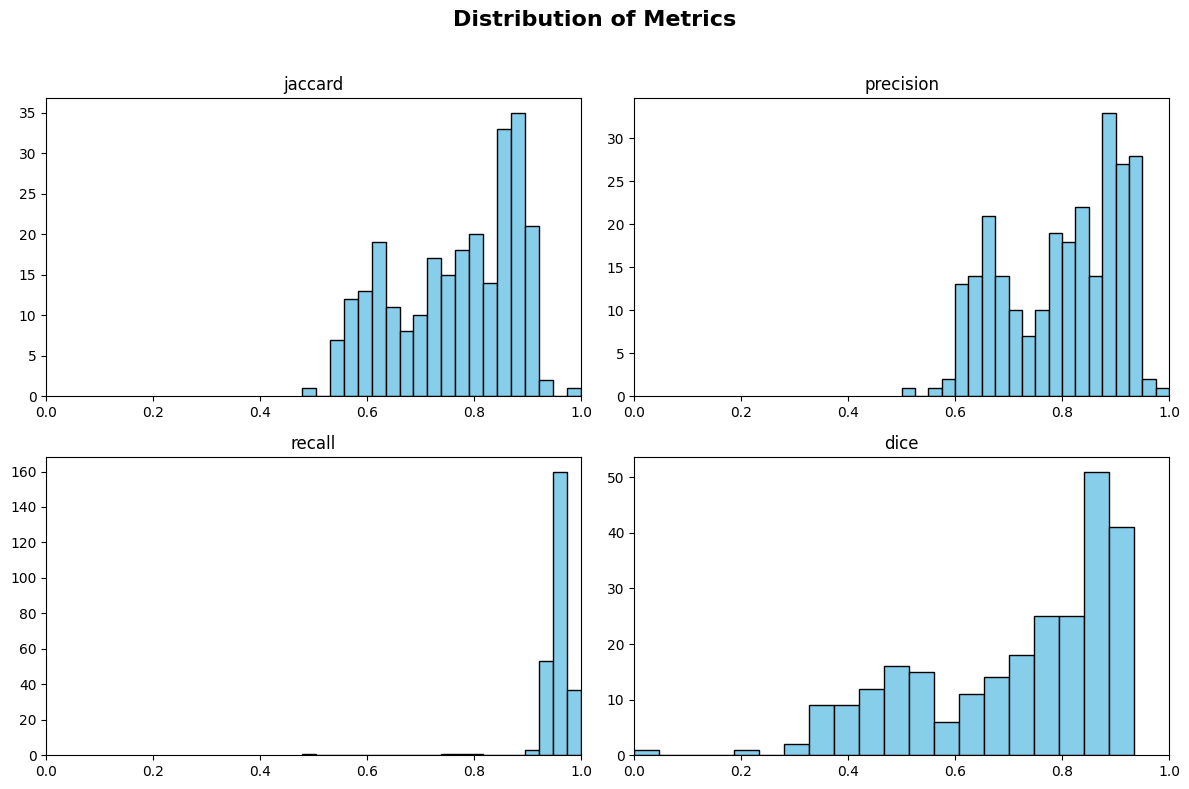

In [22]:
axes = metrics_df.hist(
    figsize=(12, 8), 
    bins=20, 
    color='skyblue', 
    edgecolor='black', 
    grid=False
)

# Set x-axis limits for all graphs
for ax in axes.flatten():
    ax.set_xlim(0, 1)

plt.suptitle("Distribution of Metrics", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Number of cells detected

In [23]:
count = []

for pred, gt in zip(predictions, ground_truth):
    count.append(
        [numpy.unique(pred).shape[0] - 1 , numpy.unique(gt).shape[0] - 1]
    )

count = pandas.DataFrame(count, columns=["Predictions", "Ground Truth"])

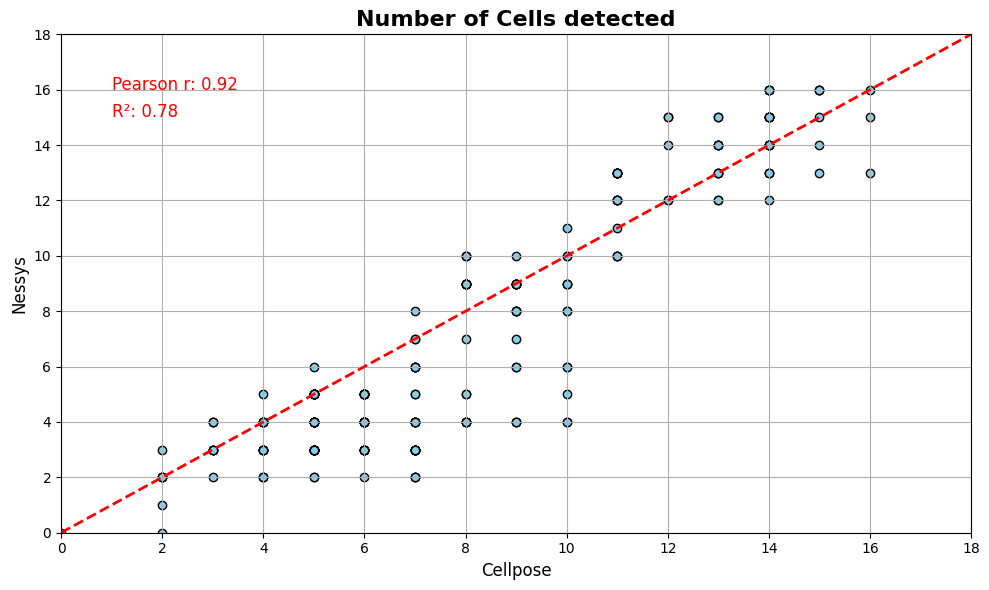

In [24]:
# Plot scatter plot
plt.figure(figsize=(10, 6))

plt.scatter(count["Predictions"], count["Ground Truth"], color='skyblue', edgecolor='black')

plt.title("Number of Cells detected", fontsize=16, fontweight='bold')
plt.xlabel("Cellpose", fontsize=12)
plt.ylabel("Nessys", fontsize=12)
plt.xlim(0, 18)
plt.ylim(0, 18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.plot([0, 18], [0, 18], color='red', linestyle='--', linewidth=2)
plt.tight_layout()

# Add pearson correlation coefficient
corr, pval = pearsonr(count["Predictions"], count["Ground Truth"])
plt.text(1, 16, f'Pearson r: {corr:.2f}', fontsize=12, color='red')
r2 = r2_score(count["Ground Truth"], count["Predictions"])
plt.text(1, 15, f'R²: {r2:.2f}', fontsize=12, color='red')

plt.show()